In [26]:
import sys
sys.path.append('../..')

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator 
from qiskit.utils import QuantumInstance
from qubap.qiskit.luciano.costfunc_barren_plateaus import global2local, test_hamiltonian_2, VQE_shift 
from qubap.qiskit.luciano.variational_algorithms import VQE, energy_evaluation, classical_solver

In [28]:
num_qubits = 8
hamiltonian_global = test_hamiltonian_2( num_qubits )

In [29]:
classical_solution = classical_solver( hamiltonian_global ).eigenvalue
classical_solution

0j

In [30]:
hamiltonian_local = global2local( hamiltonian_global )
hamiltonian_local

PauliSumOp(SparsePauliOp(['IIIIIIII', 'ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ'],
              coeffs=[ 0.5   +0.j, -0.0625+0.j, -0.0625+0.j, -0.0625+0.j, -0.0625+0.j,
 -0.0625+0.j, -0.0625+0.j, -0.0625+0.j, -0.0625+0.j]), coeff=1.0)

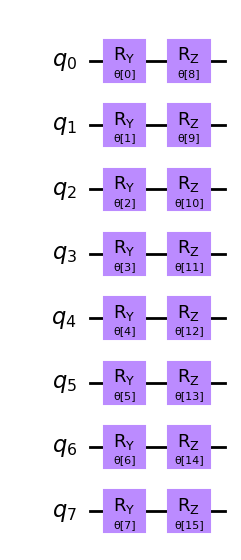

In [31]:
reps   = 0
ansatz = EfficientSU2( num_qubits, ['ry','rz'], 'circular', reps ).decompose()
ansatz.draw('mpl') 

In [32]:
npars = 2*num_qubits*( reps + 1 )
pars  = np.random.randn( npars ) * np.pi
quantum_instance = QuantumInstance( AerSimulator() , shots = 2**4 )

In [33]:
energy_evaluation( hamiltonian_global, ansatz, pars, quantum_instance )

1.0

In [34]:
num_iters = 300

In [35]:
results_global = VQE( hamiltonian_global, ansatz, pars, num_iters, quantum_instance )
data_global    = [ energy_evaluation( hamiltonian_global, ansatz, x, AerSimulator(method='statevector') ) for x in results_global ]

In [36]:
results_shift = VQE_shift( hamiltonian_global, ansatz, pars, num_iters, num_iters//3, quantum_instance ) 
data_shift    = [ energy_evaluation( hamiltonian_global, ansatz, x, AerSimulator(method='statevector') ) for x in results_shift ] 

c:\Users\lucia\miniconda3\lib\site-packages\numpy\ma\core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


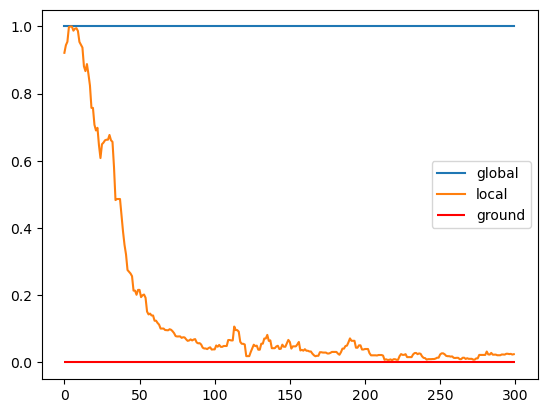

In [37]:
plt.plot( data_global )
plt.plot( data_shift  )
plt.hlines( classical_solution, 0, num_iters, 'r' )
plt.legend(['global','local','ground'])